# Is the perfect dependence always the worst?

In [1]:
from dependence import ImpactOfDependence
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt
%load_ext autoreload
%matplotlib inline
%autoreload 2

## The function and probabilistic model

In [2]:
def func_overflow(X, model=1):
    """
    X : input variables, shape : N x 8
    """
    X = np.asarray(X)
    if X.shape[0] == X.size: # It's a vector
        n = 1
        dim = X.size
        ids = None
    else:
        n, dim = X.shape
        ids = range(n)
    assert dim == 8, "Incorect dimension : dim = %d != 8" % dim
    
    Q = X[ids, 0]
    Ks = X[ids, 1]
    Zv = X[ids, 2]
    Zm = X[ids, 3]
    Hd = X[ids, 4]
    Cb = X[ids, 5]
    L = X[ids, 6]
    B = X[ids, 7]
    
    H = (Q / (B * Ks * np.sqrt((Zm - Zv) / L)))
    S = Zv + H - Hd - Cb
    
    if model == 1:
        return S
    elif model == 2:
        Cp = (S > 0.) + (0.2 + 0.8 * (1. - np.exp(-1000. / (S**4)))) * (S <= 0.) + 1./20. * (Hd * (Hd > 8.) + 8*(Hd <= 8.))
        return Cp

In [3]:
tmp = ot.Gumbel(1013., 558., ot.Gumbel.MUSIGMA)
dist_Q = ot.TruncatedDistribution(tmp, 500., 3000.)
dist_Ks = ot.TruncatedNormal(30., 8., 15., np.inf)
dist_Zv = ot.Triangular(49., 50., 51.)
dist_Zm = ot.Triangular(54., 55., 56.)
dist_Hd = ot.Uniform(7., 9.)
dist_Cb = ot.Triangular(55., 55.5, 56.)
dist_L = ot.Triangular(4990., 5000., 5010.)
dist_B = ot.Triangular(295., 300., 305.)
margins = [dist_Q, dist_Ks, dist_Zv, dist_Zm, dist_Hd, dist_Cb, dist_L, dist_B]
var_names = ["Q", "K_s", "Z_v", "Z_m", "H_d", "C_b", "L", "B"]
dim = len(margins)
corr_dim = dim * (dim - 1) / 2

### At independence

In [4]:
n = 10000
alpha = 0.99
families = np.zeros((dim, dim))
impact_indep = ImpactOfDependence(func_overflow, margins, families)
impact_indep.run_independence(n)
indep_quantile = impact_indep.compute_quantiles(alpha).quantity

## The impact of dependence

In [5]:
K = 100
results = {}
labels = []
extra_label = []

k = 0
for i in range(dim):
    for j in range(i):
        families = np.zeros((dim, dim))
        families[i, j] = 1
        impact_flood = ImpactOfDependence(func_overflow, margins, families)
        impact_flood.run(K, n, fixed_grid=True)
        results[i, j] = impact_flood
        labels.append("$%s$\n$%s$" % (var_names[i], var_names[j]))
        extra_label.append("$%s$ vs $%s$" % (var_names[i], var_names[j]))

In [6]:
quantiles = {}
params = {}
max_quantiles = []
min_quantiles = []
pairs = []
for i in range(dim):
    for j in range(i):
        impact = results[i, j]
        res = impact.compute_quantiles(alpha)
        quantiles[i, j] = res.quantity
        params[i, j] = res.cond_params
        max_quantiles.append(res.quantity.max())
        min_quantiles.append(res.quantity.min())
        pairs.append([i, j])

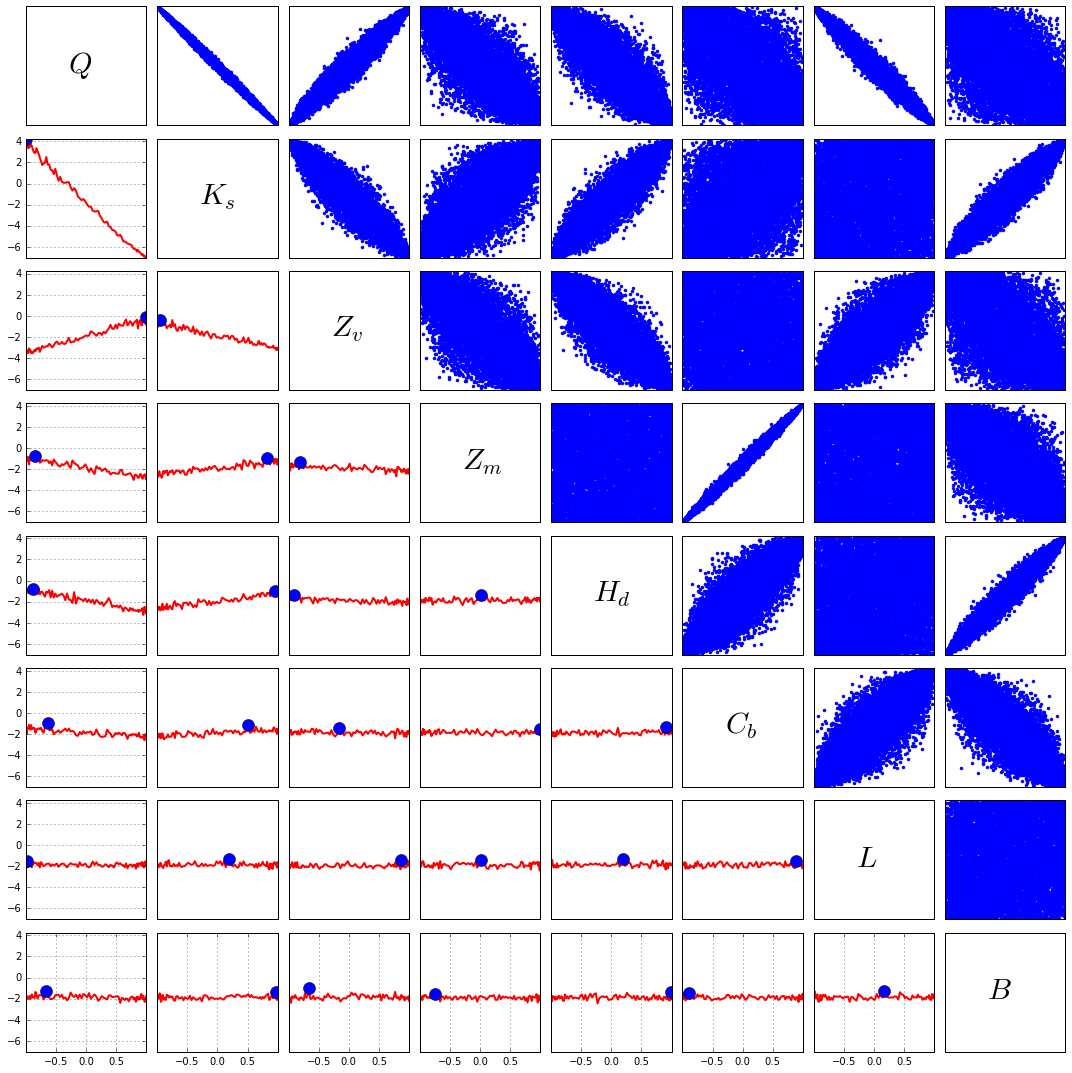

In [7]:
fig, axes = plt.subplots(dim, dim, figsize=(15, 15))
for i in range(dim):
    for j in range(i):
        ax = axes[i, j]
        quantile = quantiles[i, j]
        param = params[i, j]
        id_max = quantile.argmax()
        ax.plot(param, quantile, 'r-', linewidth=2)
        ax.plot(param[id_max], quantile[id_max], 'bo', markersize=12)
        ax.set_ylim(min(min_quantiles), max(max_quantiles))
        ax.set_xticks([])
        
        if j > 0:
            ax.set_yticks([])
        if i == dim-1:
#             ax.set_xlabel(var_names[j])
            ax.set_xticks([-0.5, 0., 0.5])
            
        ax.grid()
        ax = axes[j, i]
        impact_flood = results[i, j]
        param = params[i, j]
        quantile = quantiles[i, j]

        max_input_sample = impact_flood._input_sample[(impact_flood.all_params_ == impact_flood._params[id_max]).all(axis=1)]
        
        x = np.asarray([impact_flood.margins[i].computeCDF(max_input_sample[k, i]) for k in range(n)])
        y = np.asarray([impact_flood.margins[j].computeCDF(max_input_sample[k, j]) for k in range(n)])        
        ax.plot(x, y, '.')
    
        ax.set_xticks([])
        ax.set_yticks([])        
    ax = axes[i, i]
    ax.text(0.35, 0.45, "$%s$" % var_names[i], fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
fig.tight_layout()
fig.savefig('./figures/matrix_plot_flood.png', dpi=200)

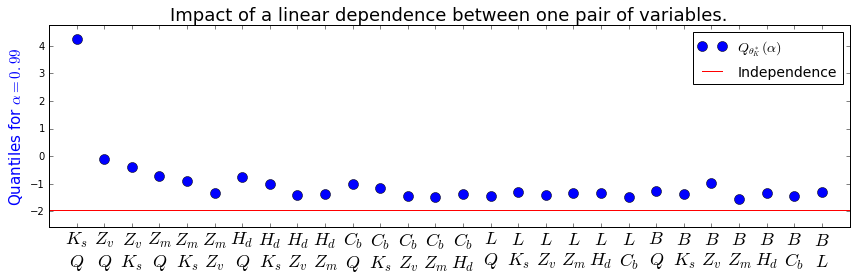

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(corr_dim), max_quantiles, "ob", label="$Q_{\\theta_K^*}(\\alpha)$", markersize=10)
ax.plot([-1, corr_dim], [indep_quantile]*2, 'r', label="Independence")
ax.set_xticks(range(corr_dim))
ax.set_xticklabels(labels, fontsize=18)
ax.set_xlim(-1, corr_dim)
ax.set_ylim(min(max_quantiles)-1., max(max_quantiles)+0.5)
ax.legend(loc=0, fontsize=14)
ax.set_ylabel("Quantiles for $\\alpha = %.2f$" % (alpha), color='b', fontsize=15)
ax.set_title("Impact of a linear dependence between one pair of variables.", fontsize=18)

fig.tight_layout()

In [9]:
n_corrs = 5
id_corrs_token = np.argsort(max_quantiles)[::-1][:n_corrs]

In [10]:
families = np.zeros((dim, dim))
for k in id_corrs_token:
    pair = pairs[k]
    families[pair[0], pair[1]] = 1
families

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [11]:
K = 3**n_corrs
impact = ImpactOfDependence(model_func=func_overflow, margins=margins, families=families)

impact.run(K, n)
quant_res = impact.compute_quantiles(alpha)
id_max = quant_res.quantity.argmax()
worst_quantile_standard = quant_res.quantity[id_max]

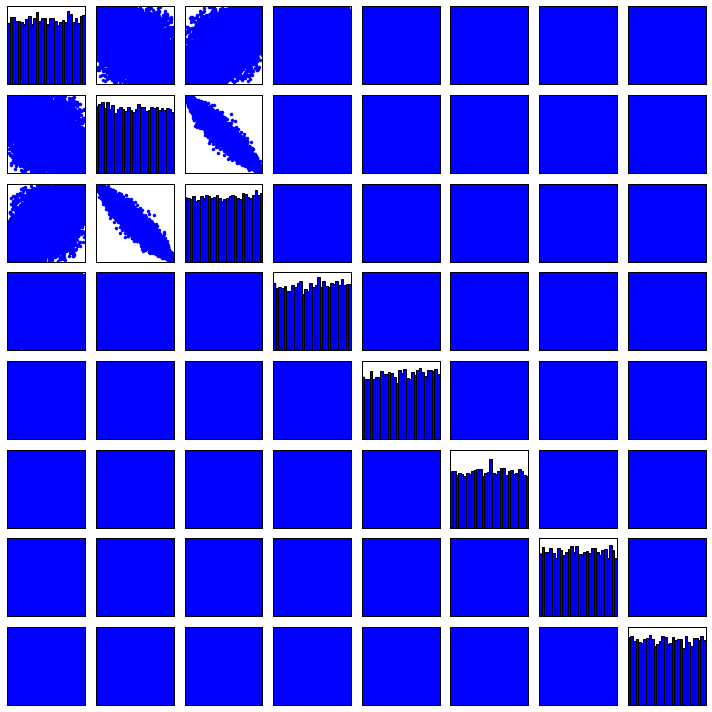

In [12]:
impact.draw_matrix_plot(id_max, copula_space=True)

## Frechet-Hoeffding

In [13]:
impact_FH = ImpactOfDependence(model_func=func_overflow, margins=margins, families=families)
impact_FH.minmax_run(n)

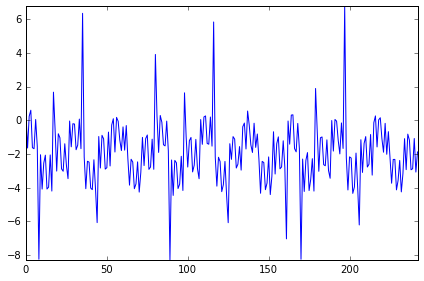

In [14]:
quant_res = impact_FH.compute_quantiles(alpha)
id_sorted = quant_res.quantity.argsort()[::-1]
id_max = id_sorted[0]
id_min = id_sorted[-1]
fig, ax = plt.subplots()
ax.plot(quant_res.quantity)
ax.axis('tight')
fig.tight_layout()
worst_quantile_FH = quant_res.quantity[id_max]
indep_quantile = quant_res.quantity[-1]
fav_quantile_FH = quant_res.quantity[id_min]

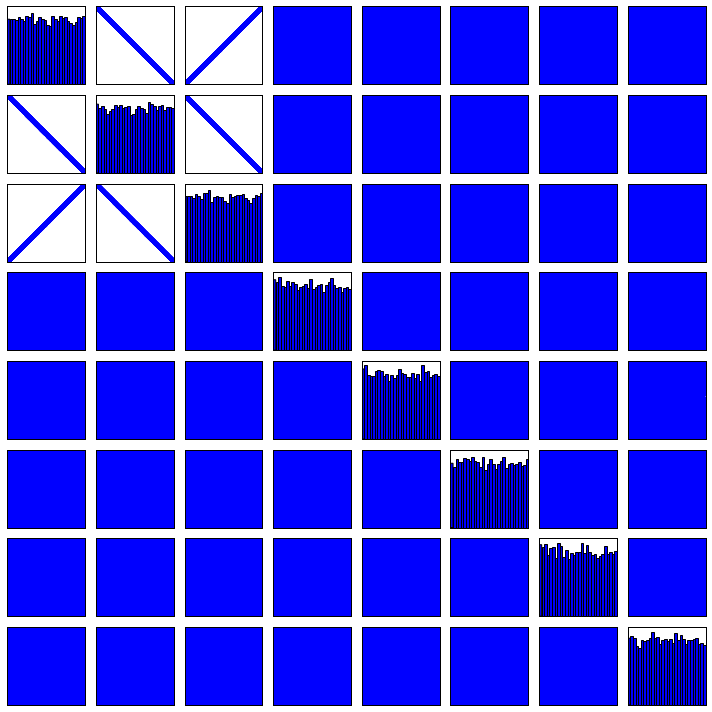

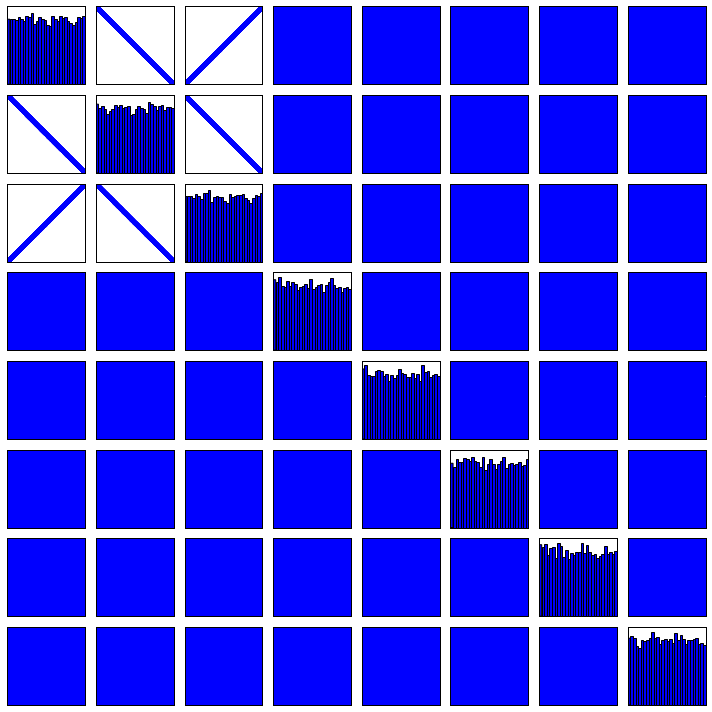

In [36]:
impact_FH.draw_matrix_plot(id_max, copula_space=True, savefig='./figures')

In [16]:
worst_quantile_standard, worst_quantile_FH

(4.1287382080276638, 6.7573935719326546)

In [17]:
print fav_quantile_FH, '<', indep_quantile, '<', worst_quantile_FH

-8.27444336439 < -1.8779216499 < 6.75739357193


In [18]:
n_alpha = 100
alphas = np.linspace(0., 1., n_alpha+1, endpoint=False)[1:]
indep_quantiles = impact_indep.compute_quantiles(alphas).quantity

In [19]:
tmp = impact_FH.compute_quantiles(alphas).quantity
min_quantiles = tmp.min(axis=1)
max_quantiles = tmp.max(axis=1)

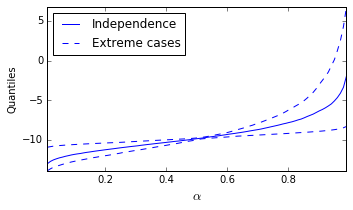

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(alphas, indep_quantiles, 'b', label='Independence')
ax.plot(alphas, min_quantiles, '--b', label='Extreme cases')
ax.plot(alphas, max_quantiles, '--b')
ax.set_ylabel('Quantiles')
ax.set_xlabel('$\\alpha$', fontsize=13)
ax.axis('tight')
ax.legend(loc=2)
fig.tight_layout()
# fig.savefig('./figures/quantile_bounds.png', dpi=200)
# fig.savefig('./figures/quantile_bounds.pdf')

In [21]:
tmp_stand = impact.compute_quantiles(alphas).quantity
min_quantiles_stand = tmp_stand.min(axis=1)
max_quantiles_stand = tmp_stand.max(axis=1)

In [32]:
alphas[0]

0.0099009900990099011

In [33]:
max_quantiles_stand[0], max_quantiles[0], indep_quantiles[0]

(-10.903898046267827, -10.884306648524259, array([-12.9679808]))

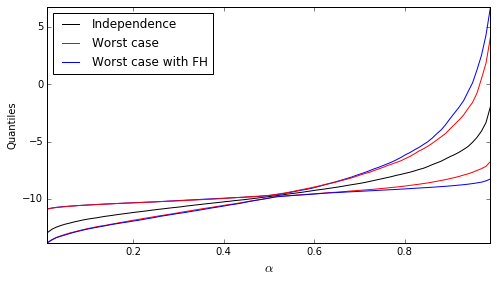

In [38]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(alphas, indep_quantiles, 'k', label='Independence')
ax.plot(alphas, min_quantiles_stand, '-r', label='Worst case')
ax.plot(alphas, min_quantiles, '-b', label='Worst case with FH')
ax.plot(alphas, max_quantiles, '-b')
ax.plot(alphas, max_quantiles_stand, '-r')
ax.set_ylabel('Quantiles')
ax.set_xlabel('$\\alpha$', fontsize=13)
ax.axis('tight')
ax.legend(loc=2)
fig.tight_layout()
fig.savefig('./figures/quantile_bounds_2.pdf')

IndexError: invalid index to scalar variable.

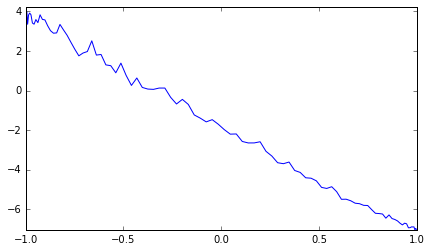

In [23]:
quants = quantiles[1, 0]
pp = params[1, 0].ravel()

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(pp, quants, '-b')
# ax.fill_between(pp, 0, quants, where=(pp < 0))
ax.axis('tight')
ax.fill_between(pp, indep_quantile[0], quants, where=(pp <= 0), color='green', alpha=0.5, interpolate=True)
ax.fill_between(pp, indep_quantile[0], quants, where=(pp >= 0), color='red', alpha=0.5, interpolate=True)
ax.set_ylabel("Quantile at $\\alpha=%.2f$" % (alpha), fontsize=14)
ax.set_xlabel("$\\theta$", fontsize=16)
fig.tight_layout()
fig.savefig('figures/impact_dependence.pdf')